In [21]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, mean_absolute_error, mean_absolute_percentage_error, median_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
import os
import pickle
from copy import deepcopy

In [14]:
def process_df(df):
  new_df = deepcopy(df)
  new_df["period_index"] = pd.PeriodIndex(df.sale_date, freq="Q")
  new_df.drop(columns=["id", "sale_date", "address", "latitude_rad", "longitude_rad", "latitude", "longitude", "psm"], inplace=True)
  new_df = pd.get_dummies(new_df, columns=["flat_type", "flat_model", "town"], dummy_na = True, dtype=np.uint8)
  new_df.drop(columns=["town_nan", "flat_type_nan", "flat_model_nan"], inplace=True)
  return new_df

In [15]:
def train_test_split(df, period):
  train = df[df["period_index"] != period]
  test = df[df["period_index"] == period]
  
  X_train, y_train = train[train.columns.difference(["cpi_psm", "period_index"])], train["cpi_psm"]
  X_test, y_test = test[test.columns.difference(["cpi_psm", "period_index"])], test["cpi_psm"]
  return X_train, X_test, y_train, y_test

In [16]:
PATH = "../../data_processed/resale_flat_prices"
SEED = 42

df = pd.read_csv(os.path.join(PATH, "engineered_data.csv"))

mean_imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
mean_imputer.fit(np.array(df["avg_sora"]).reshape(-1, 1))
df["avg_sora"] = mean_imputer.transform(np.array(df["avg_sora"]).reshape(-1, 1))


In [18]:

new_df = process_df(df)
sample_values = new_df.sample(frac=0.1)
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(sample_values, pd.Period(value="2022Q3"))

### Selecting parameters using sampled data

In [41]:
#defining potential parameters
param = [{'n_neighbors': [2,4,8], 
          'weights': ['uniform','distance'],
          'p':[1,2], 'n_jobs':[-1]}]
#defining evaluation
#defining scorer

#defining grid search
grid = GridSearchCV(estimator = KNeighborsRegressor(), 
                      param_grid = param, 
                      verbose = 4,  
                      scoring = 'neg_root_mean_squared_error',
                      return_train_score = True,
                      #refit=False
                    )

#executing grid search
result = grid.fit(X_train_sample,y_train_sample)

#summarising result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END n_jobs=-1, n_neighbors=2, p=1, weights=uniform;, score=(train=-314.057, test=-556.932) total time=  28.8s
[CV 2/5] END n_jobs=-1, n_neighbors=2, p=1, weights=uniform;, score=(train=-312.144, test=-577.918) total time=  27.3s
[CV 3/5] END n_jobs=-1, n_neighbors=2, p=1, weights=uniform;, score=(train=-315.372, test=-562.054) total time=  27.8s
[CV 4/5] END n_jobs=-1, n_neighbors=2, p=1, weights=uniform;, score=(train=-314.229, test=-578.042) total time=  26.1s
[CV 5/5] END n_jobs=-1, n_neighbors=2, p=1, weights=uniform;, score=(train=-311.052, test=-572.203) total time=  28.0s
[CV 1/5] END n_jobs=-1, n_neighbors=2, p=1, weights=distance;, score=(train=-10.084, test=-548.590) total time=  26.0s
[CV 2/5] END n_jobs=-1, n_neighbors=2, p=1, weights=distance;, score=(train=-10.875, test=-568.825) total time=  26.7s
[CV 3/5] END n_jobs=-1, n_neighbors=2, p=1, weights=distance;, score=(train=-10.112, test=-553.089) total 

In [42]:
pickle.dump(grid, open("grid_knn_v2.sav", "wb"))
grid.score(X_test_sample, y_test_sample)

-875.121735286981

### Training with the best estimator

In [56]:
#K Neighbors regression with best estimator
model = result.best_estimator_

X_train, X_test, y_train, y_test = train_test_split(new_df, pd.Period(value = "2022Q3"))

In [59]:
print(X_test.shape)
print(y_test.shape)

(4773, 56)
(4773,)


In [57]:
model.fit(X_train, y_train)

KNeighborsRegressor(n_jobs=-1, n_neighbors=4, p=1, weights='distance')

In [58]:

y_pred = model.predict(X_test)
model.score(X_test, y_test)

0.8304149705370834

In [60]:
pickle.dump(model, open("final_model_knn_v2.pkl", "wb"))

### Model analysis

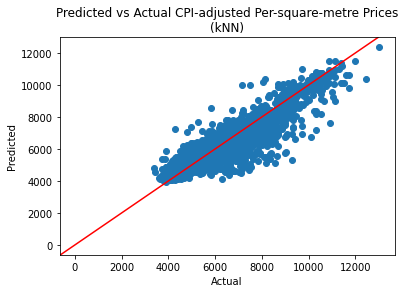

In [61]:
plt.scatter(y_test, y_pred)
plt.title("Predicted vs Actual CPI-adjusted Per-square-metre Prices\n(kNN)")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.axline((0, 0), slope=1, color="red")
plt.show()

In [62]:

def produce_metrics(y_test, y_pred):
  mse = mean_squared_error(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  rtwo = r2_score(y_test, y_pred)
  mape = mean_absolute_percentage_error(y_test, y_pred)
  mdape = median_absolute_error(y_test, y_pred)/np.median(y_test)
  return mse, mse**(0.5), mae, rtwo, mape, mdape

In [63]:
mse, rmse, mae, rtwo, mape, mdape = produce_metrics(y_test, y_pred)
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2: {rtwo}")
print(f"MAPE: {mape}")
print(f"MdAPE: {mdape}")

MSE: 287519.4871288393
RMSE: 536.2084362716045
MAE: 351.05745057905375
R2: 0.8304149705370834
MAPE: 0.05906290626563422
MdAPE: 0.04294364570072642


In [64]:
pred_df = pd.merge(pd.Series(y_test, name="y_test").reset_index(drop=True), pd.Series(y_pred, name="y_pred"), right_index=True, left_index=True)

In [65]:
pred_df.to_csv("pred_df_2.csv")

In [66]:
neg_test = y_test - y_pred
print(neg_test)
print(y_test)

861054    -665.178572
861055     -95.926875
861056     173.818207
861057     249.801440
861058    1137.996437
             ...     
865822    -722.907606
865823    -397.389965
865824    -466.020098
865825     209.474920
865826     620.919426
Name: cpi_psm, Length: 4773, dtype: float64
861054    6054.945055
861055    6932.869145
861056    5968.135807
861057    6402.182047
861058    7271.286988
             ...     
865822    4373.831776
865823    6170.212766
865824    5705.882353
865825    5671.641791
865826    6450.336283
Name: cpi_psm, Length: 4773, dtype: float64


In [67]:
print(y_pred)

[6720.12362657 7028.79601975 5794.31759986 ... 6171.90245078 5462.16687148
 5829.41685707]
